# HW 2
In this homework assignment, **we are going to help Citibike determine where to place more stations across NYC**. 

The Citi Bike program in New York City is a bike-sharing initiative that provides residents and visitors with access to bicycles for short-term rentals. It was launched in New York City in May 2013, making it one of the oldest and most established bike-sharing programs in the United States. The program caters to a diverse range of users, including commuters, tourists, and residents of New York City. 

Citi Bike makes siting decisions based on a combination of factors, including **population density**, **transportation needs**, and **input from the community**. The program continually evaluates and adjusts the locations of its bike stations to meet the evolving demand for bike-sharing services. 

**For this exercise, we are going to consider a simplified version of these factors and help Citibike figure out 10 block groups to put new bike stations in.**


#### Deliverables
- This notebook, no need to zip

## Part 1: Gathering our data

We've done the hard part for you! In this folder, you should find three new datasets 
- `bike_locations_dec2023.csv`
- `nyc_cbg.zip`
- `acs_race_cbg.csv`

In [1]:
import pandas as pd
import geopandas as gpd

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
bike_locations= pd.read_csv('bike_locations_dec2023.csv')

In [3]:
bike_locations.head()

,station_id,lng,lat
0,2782.02,-74.019810,40.635819
1,2821.05,-74.013099,40.635455
2,2883.03,-74.024714,40.638246
3,2912.08,-74.013800,40.638235
4,2961.05,-74.015726,40.640125


Now turn the bike locations dataframe into a geodataframe (3 pts)

In [4]:
# INSERT YOUR CODE HERE
gdf_bike = gpd.GeoDataFrame(bike_locations, 
                            geometry=gpd.points_from_xy(bike_locations['lng'], bike_locations['lat']),
                            crs='EPSG:4326')

Now calculate a 10 minute walk from the locations in meters and find the 10-min walk buffer for each station. Make sure to turn it into a geodataframe. (5 pts)

In [5]:
#in order to calculate distances in meters I convert to epsg=3857
gdf_bike = gdf_bike.to_crs(epsg=3857)

#from in-class assignment I know that buffer geometry is around 800m
buffer_geom = gdf_bike['geometry'].buffer(800)

buffer_crs = gdf_bike.crs 
buffer_data = gdf_bike[['station_id', 'lng', 'lat']]  

bike_buffer = gpd.GeoDataFrame(buffer_data, 
                                         crs=buffer_crs, 
                                         geometry=buffer_geom)

Plot the data (1 pt)

<Axes: >

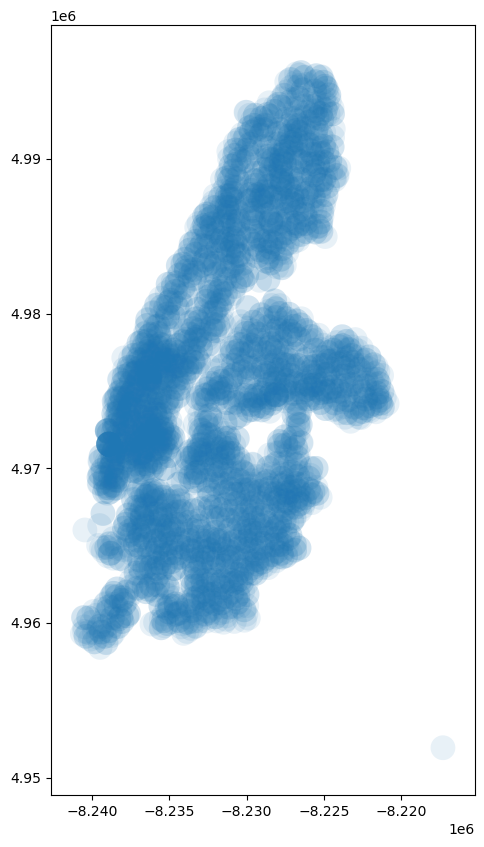

In [6]:
#plotting just edges was very confusing, so I instead plot the shapes with a semi-transparent fill

# bike_buffer.plot(figsize=(15,15),
#                   facecolor="none", 
#                   edgecolor="green", 
#                   lw=.5)

bike_buffer.plot(figsize=(10,10), alpha=0.1) 

Now read in the block group geometries, which are in the `nyc_cbg` zip file (1pt)

In [7]:
blocks = gpd.read_file("nyc_cbg")

#we also set the crs to be consistent with the bikes
blocks = blocks.to_crs(epsg=3857)

And read in the block group attribute tables (1pt)

In [8]:
attributes= pd.read_csv('acs_race_cbg.csv')

Create a column in your block group geometries geodataframe called `area`, which will have the area of each Block Group (1 pt)

In [9]:
blocks['area']=blocks.area

Replace the `NaN` values with 0 (1 pt)

In [10]:
# there are no NaN values in the blocks (all geometry area>0)
#print(blocks.isna().sum()) #uncomment to see

# the NaN in the attribute table is all in the Population_density column
#print(attributes.isna().sum()) #uncomment to see

#since I know population density is a number, I will just replace all NaN with 0
attributes = attributes.fillna(0)

#I check there's no NaN just in case
attributes.isna().sum() #all 0s, great!

Unnamed: 0            0
GISJOIN               0
COUNTY                0
Population            0
Population_density    0
Hispanic              0
White                 0
Black                 0
Native                0
Asian                 0
Pacific               0
dtype: int64

Merge the attribute data with the geometries. 

In [11]:
# we need the geometry for later analysis, so I will merge attributes into blocks (and not other way around)
block_groups= blocks.merge(attributes, left_on="GISJOIN", right_on="GISJOIN")

#the unnamed column doesn't seem to represent anything, so I will drop it
block_groups.drop(columns="Unnamed: 0", inplace=True)

How many rows do you have in your new merged dataframe and how many row did you have originally in the geometry dataframe? (1pt)

In [12]:
row_prev, _ =blocks.shape
row_curr, _ = block_groups.shape
print(f"rows in merged: {row_curr}, original rows in geometry dataframe: {row_prev}")

#that is, there are the same number of rows
#this is expected, as I merged the attributes into the geometry, and there is an attribute for each geometry
#more specifically, there are more attributes than geometry, but we disregard those that didn't match a geometry

rows in merged: 6592, original rows in geometry dataframe: 6592


## Part 2 - Analysis
Now, Citi Bike says they can put 10 new stations across 10 different block groups not currently within walking distance to a station. 


Here are the factors important to them (in no order): 
- **Proportion of block group not covered** (for ex: if a bg is 90% not covered by 10% not covered, they will prioritize the 90%)
- **Population density**: They would rather put a station in a block group that has more people per block
- **Proximity to the city center**: They know that many people use Citibike to get to work, so they would prefer for these stations to be as close to downtown Manhanttan as possible
- **Equity**: They hope to put these stations where the proportion of non-White residents is high. 

First, create a new dataframe of Census block groups not covered by the Citi bike walking buffers. Make sure to check your CRSs. (5pts)

In [13]:
#I first join the bike buffer geometry using dissolve to find all the area covered
total_area_covered = bike_buffer.dissolve()

#then I use overlay difference to find the block groups that are now covered by bikes
uncovered_blocks = block_groups.overlay(total_area_covered, how="difference")

How many block groups are not covered? (1 pt)

In [14]:
#number of blocks is just length of remaining blocks after overlay difference
len_, _ = uncovered_blocks.shape
print(len)

#there are 206 groups that have partial intersections with bike stations(and the rest are completely uncovered by bike stations)
#uncovered_blocks[uncovered_blocks["area"] != uncovered_blocks["uncovered_area"]]

<built-in function len>


Now, let's create the proportion of the block group that hasn't been covered (3 pts)

In [15]:
uncovered_blocks["uncovered_area"] = uncovered_blocks.area
uncovered_blocks["uncovered_proportions"] = uncovered_blocks.area / uncovered_blocks["area"]

Next, let's calculate distance from each centroid of the not covered block groups to Manhattan city center. 

First, what's our current CRS? Let's convert our uncovered block group geodataframe CRS to 3857. (1 pt)

In [16]:
# current crs is already 3857, but here's the code conversion anyway:
uncovered_blocks.to_crs(epsg=3857)

#I assert this just in case
assert uncovered_blocks.crs =="EPSG:3857"

Next we want to find the distance between each block group and downtown Manhttan. 

Using chatgpt, find the lat/lng for Downtown Manhattan in EPSG: 3857. Was it correct? (2 pts) By correct, I don't mean whether the location in the city was correct (you can use anywhere below Central Park as "downtown"), but whether the format and CRS were correct. 

the first answer it gave me was in EPSG:4326, and not in EPSG:3857
<li>Latitude: 40.7219, Longitude: -74.0032</li>

after some prompting, it gave me the correct crs, but the location was in brooklyn 
<li>X: -8236575.988, Y: 4968480.521</li>

then finally, after more prompting, it gave a correct answer:
<li>X: -8238480.943, Y: 4971068.849</li>


Create a geodataframe with one point in Downtown Manhattan with a 3857 CRS (5 pts)

In [17]:
# I'm using Astor Place as my downtown location, which approximately has (x,y) = (-8236653.33779, 4972575.11631)
downtown_pt = gpd.GeoDataFrame(geometry=gpd.points_from_xy([-8236653.33779], [4972575.11631]), crs="epsg:3857")

Find the distance between this point and all uncovered block groups (3 pts)

In [18]:
#first we check they have the same crs (epsg: 3857)
downtown_pt.crs == uncovered_blocks.crs

#we calculate the distance and store it in a column
uncovered_blocks["distance_to_downtown"]  = uncovered_blocks["geometry"].centroid.distance(downtown_pt.iloc[0]["geometry"])

We already know the population density.

Lastly, find the percent non-white residents in each block group (3 pts)

In [19]:
# I created a function to calculate proportions that guards against 0 division. 
# if there are no people in the group, then I just set the proportion to 0
def non_white_proportions(row):
  if row["Population"] ==0:
    return 0
  else:
    return 1 - row["White"] / row["Population"]

#I store this in a new column
uncovered_blocks["non-white resident proportions"] = uncovered_blocks.apply(non_white_proportions, axis=1)

In [20]:
#there is one row with population density as inf, so I replace it with 0
uncovered_blocks.loc[uncovered_blocks["Population_density"]==float('inf'), "Population_density"] = 0

#I overview the data to for sanity
uncovered_blocks.describe()

,area,Population,Population_density,Hispanic,White,Black,Native,Asian,Pacific,uncovered_area,uncovered_proportions,distance_to_downtown,non-white resident proportions
count,3.201000e+03,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3.201000e+03,3201.000000,3201.000000,3201.000000
mean,3.195493e+05,1293.789441,0.015823,287.018119,380.700406,298.541081,3.976257,254.146204,0.473602,3.030017e+05,0.964146,21251.393776,0.688396
std,8.981356e+05,559.348778,0.013742,269.361803,421.981270,419.437289,8.862001,319.148681,1.406016,8.707392e+05,0.158321,5500.045564,0.297934
min,9.966227e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.287049e+00,0.000022,6861.736909,0.000000
25%,1.057568e+05,949.000000,0.007345,107.000000,36.000000,16.000000,0.000000,34.000000,0.000000,1.007576e+05,1.000000,16943.446675,0.448780
50%,1.642406e+05,1239.000000,0.012711,197.000000,228.000000,76.000000,1.000000,126.000000,0.000000,1.598272e+05,1.000000,20500.531111,0.776018
75%,2.841095e+05,1602.000000,0.020522,379.000000,602.000000,487.000000,4.000000,374.000000,0.000000,2.784648e+05,1.000000,25133.283021,0.966596
max,3.185419e+07,3946.000000,0.251360,2077.000000,2650.000000,2521.000000,126.000000,2731.000000,33.000000,3.185419e+07,1.000000,44014.698885,1.000000


Lastly, create you own method of finding your top 10 block groups based on these criteria. You must you all four criteria from above. Please explain how you decided on your method and which criteria to prioritize. (10 pts) 

Here are some ideas: 
- You can create a threshold for each column and find the 10 block groups that fulfill all criteria (for ex: `perc_non_white` has to be greater than 50%, etc etc)
- You can create a score that combines all four criteria in some way. 



In [21]:
# I wanted to combine all four criteria to one score
# given that they are in different ranges, I normalize all values to be in [0,1]

# I created a normalization function and pass all four criteria through it
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

uncovered_proportions_norm = normalize_column(uncovered_blocks["uncovered_proportions"])
Population_density_norm = normalize_column(uncovered_blocks["Population_density"])
distance_to_downtown_norm = normalize_column(uncovered_blocks["distance_to_downtown"])
non_white_resident_proportions_norm = normalize_column(uncovered_blocks["non-white resident proportions"])

In [22]:
# I examine what the distributions are
pd.concat([uncovered_proportions_norm, Population_density_norm, distance_to_downtown_norm, non_white_resident_proportions_norm], axis=1).describe()

,uncovered_proportions,Population_density,distance_to_downtown,non-white resident proportions
count,3201.000000,3201.000000,3201.000000,3201.000000
mean,0.964145,0.062951,0.387308,0.688396
std,0.158324,0.054669,0.148038,0.297934
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.029222,0.271357,0.448780
50%,1.000000,0.050569,0.367098,0.776018
75%,1.000000,0.081643,0.491792,0.966596
max,1.000000,1.000000,1.000000,1.000000


In [23]:
# this seems very reasonable, so I now make a score
# I know that for uncovered_proportions, population density, and non-white resident proportions, the higher the number the better
# and that for distance_to_downtown, the lower the number the better
# I weigh these categories equally, and add up first categories then subtract by distance_to_downtown:

score = uncovered_proportions_norm+Population_density_norm-distance_to_downtown_norm+non_white_resident_proportions_norm

#I set this as a column
uncovered_blocks["score"] = score


In [24]:
#I sort by score, listing the highest first
uncovered_blocks = uncovered_blocks.sort_values(by="score", ascending=False)

# I plotted them interactively, and checked that they are what I expected. 
# The top 30 are much higher in all categories (other than distance to downtown)
# And the bottom 30 are much lower in all categories except for distance

m = uncovered_blocks.head(30).explore()
uncovered_blocks.tail(30).explore(m=m, color="red")

In [25]:
#lastly, I show the 10 groups I recommend to place Citi bikes in:
uncovered_blocks.head(10)

,GISJOIN,COUNTYFP,geometry,area,COUNTY,Population,Population_density,Hispanic,White,Black,Native,Asian,Pacific,uncovered_area,uncovered_proportions,distance_to_downtown,non-white resident proportions,score
538,G36000500462062,005,"POLYGON ((-8218518.745 4993910.957, -8218549.5...",15128.187893,Bronx County,2172,0.251360,523,92,1445,18,35,0,15128.187893,1.0,28044.534808,0.957643,2.387492
2338,G36008100797012,081,"POLYGON ((-8217982.864 4976179.446, -8217976.9...",33594.607075,Queens County,3309,0.171816,236,93,181,8,2731,0,33594.607075,1.0,18857.549840,0.971895,2.332564
540,G36000500462064,005,"POLYGON ((-8218594.665 4994039.777, -8218626.6...",12667.490259,Bronx County,1239,0.171251,278,47,865,5,21,0,12667.490259,1.0,27980.210251,0.962066,2.074944
178,G36000500212003,005,"POLYGON ((-8221596.504 4988166.474, -8221572.9...",32339.986563,Bronx County,2059,0.111333,538,34,662,10,753,0,32339.986563,1.0,21605.577446,0.983487,2.029570
1384,G36004700912003,047,"POLYGON ((-8227086.234 4962776.076, -8227193.6...",98054.252958,Kings County,2870,0.050921,841,12,1882,7,31,0,98054.252958,1.0,13482.110695,0.995819,2.020208
1378,G36004700910001,047,"POLYGON ((-8226865.488 4963287.667, -8227064.9...",72131.518292,Kings County,1732,0.041777,534,9,1113,8,3,0,72131.518292,1.0,13308.812723,0.994804,1.987481
42,G36000500050012,005,"POLYGON ((-8223965.156 4986410.000, -8224068.4...",34277.370678,Bronx County,1498,0.076397,1165,9,295,1,13,0,34277.370678,1.0,18830.649615,0.993992,1.975776
1549,G36004701156003,047,"POLYGON ((-8226043.394 4963448.515, -8226143.4...",47599.239199,Kings County,1195,0.043683,505,14,653,0,3,0,47599.239199,1.0,13840.939150,0.988285,1.974222
2408,G36008100863003,081,"POLYGON ((-8217390.867 4977222.284, -8217456.1...",29165.777365,Queens County,1554,0.092965,245,83,37,0,1171,0,29165.777365,1.0,19608.290474,0.946589,1.973354
1383,G36004700912002,047,"POLYGON ((-8227131.319 4963003.985, -8227349.6...",96455.104224,Kings County,2053,0.037030,681,33,1231,4,19,1,96455.104224,1.0,13289.369145,0.983926,1.958242
